In [28]:
# torch를 사용할 때 필요한 판다스, 넘파이, glob, matplotlib 등 다양한 모듈들을 빠르게 불러와준다.
from torch_snippets import *
# 이미지 분석 및 처리를 쉽게 할 수 있게 해주는 라이브러리 
from PIL import Image

In [29]:
IMAGE_ROOT = './dataset/images/images'
df_raw = df = pd.read_csv('./dataset/df.csv')
df_raw

In [30]:
label2target = {l : t + 1 for t,l in enumerate(df_raw['LabelName'].unique())}
label2target['background'] = 0
target2label = {t : l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)
print('target2label : {}'.format(target2label))
print('label2target : {}'.format(label2target))

target2label : {1: 'Bus', 2: 'Truck', 0: 'background'}
label2target : {'Bus': 1, 'Truck': 2, 'background': 0}


In [31]:
def preprocessing_image(img):
    # permute tensor의 차원을 바꿔준다. 2,0,1 차원에 있던 값들을 0,1,2 차원에 순서대로 넣어준다.
    # w,h,chennels 순으로 들어와 있기 때문에 Channels,w,h 순으로 바꿔준다.
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [32]:
class OpenDataset(torch.utils.data.Dataset):
    # 다양한 이미지 크기를 224 * 224로 바꿔주기 위해 속성값 넣어주기
    w,h = 224, 224
    def __init__(self,df,image_dir = IMAGE_ROOT):
        self.image_dir = image_dir
        self.df = df
        # 이미지 경로 + /* 를 해줘서 glob의 input형태를 맞춰준다.
        self.files = glob.glob(self.image_dir + '/*')

        # image_infos 에 데이터 프레임의 ImageID의 중복되지않은 값들을 넣어준다.
        # 15225개, 넘파이 array로 들어간다.
        self.image_infos = df.ImageID.unique()
    
    def __getitem__(self,ix):
        # image_infos 에서 인덱스로 접근해 image_id에 담아준다.
        image_id = self.image_infos[ix]
        
        # torch_snippets를 사용해 사용할 수 있는 find는 image_id 에 담겨있는 것들이 self.files에 포함되어 있다면 출력해준다.
        # print(find('asd', ['qweasd','qweacs','xzcasdc','qwecxn]))  =>  ['qweasd','xzcasdc']
        img_path = find(image_id,self.files)

        # 이미지를 열 때, BGR 로 열리는 이미지를 RGB로 열어준다.
        img = Image.open(img_path).convert('RGB')

        # 이미지를 resize 하는데 객체 속성 값인 224 * 224 로 해준다. 
        img = np.array(img.resize((self.w,self.h), resample=Image.BILINEAR)) / 255.

        # image_id 와 df['ImageID']에서 동일한 값만 갖는 내용을 dataframe에서 뽑아온다.
        data = df[df['ImageID'] == image_id]
        # 뽑아온 data에서 LabelName 에 해당하는 값들만 리스트로 담아 labels에 저장한다.
        labels = data['LabelName'].values.tolist()

        # 뽑아온 data에서 XMin, YMin, XMax, YMax 의 값들을 data에 다시 초기화 시켜준다.
        data = data[['XMin','YMin','XMax','YMax']].values
        
        # 절대 좌표로 변환
        # data에는 [[Xmin, Ymin, Xmax, Ymax],[Xmin, Ymin, Xmax, Ymax],[Xmin, Ymin, Xmax, Ymax]...] 값들이 순서대로 들어가있는 상태이다.
        # [:,0,2] = [[Xmin, Xmax],[Xmin,Xmax]...] 에 224의 값을 모두 곱해준다.
        # [:,1,3] = [Ymin, Ymax],[Ymin,Ymax]...] 에 224의 값을 모두 곱해준다.
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        # boxes 변수에 dat를 담아주는데 모두 양수의 값이기 때문에 uint32를 자료형으로 변형해고 리스트에 담아 저장해준다.        
        boxes = data.astype(np.uint32).tolist()

        # pytorch Faster- RCNN 모델은 텐서의 dictionary type 으로 ground truth를 받는다.
        # ground truth 는 우리가 탐지하고자 하는 객체의 위치를 labeling 한 값을 의미한다.
        target = {}
        target['boxes'] = torch.Tensor(boxes).float()
        target['labels'] = torch.Tensor([label2target[i] for i in labels]).long()
        print(target)
        
        # 위에서 정의한 preprocessing_image 함수를 통해 이미지를 받아온다.
        img = preprocessing_image(img)
        return img, target

    # 보통 torch 의 tensor를 받지만 여기서는 dict 타입을 받는다.
    def collate_fn(self,batch):
        return tuple(zip(*batch))

    # 길이를 출력하면 df['ImageID']의 unique 값의 길이가 출력된다.
    def __len__(self):
        return len(self.image_infos)

In [33]:
# 반가운 sklearn train_test_split
# dataframe에서 ImageID의 유니크 값들 중 train_size = 90%, test_size = 10%, Random_State 값을 99로 맞춰주고 trn_ids, val_ids로 나눠 담는다. 
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df['ImageID'].unique(),test_size=0.1, random_state=99)
# dataframe의 ImageID 에서 trn_dis가 있는 행들만 trn_df, val_ids가 있는 행들만 val_df에 담는다.
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]

# 위에서 정의한 OpenDataset class에 df = trn_df ,image_dir 는 default 값으로 넣어 훈련, 검증용 인스턴스를 각각 정의한다.
train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)
print('훈련용 dataset 크기 : {}\n검증용 dataset 크기 : {}'.format(len(train_ds),len(test_ds)))
print('이미지 파일 경로 : {}'.format(train_ds.image_dir))
# print('정보가 저장되어 있는 데이터 프레임 : {}'.format(train_ds.df))
print('이미지 파일의 이름들 : {}'.format(train_ds.image_infos))

# train_ds를 넣어주면 OpenDataset Class의 __getitem__ method에 있는 return 값들이 index값에 따라 반환된다. 
# batch_size = 4
# batch sample로 묶인 이후에는 collate_fn을 호출해 묶어준다.
# drop_last 는 배치사이즈에 맞지 않는 마지막데이터는 버린다는 의미이다.
train_loader = DataLoader(train_ds, batch_size = 4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [34]:
# vision 과 관련된 torch의 모듈 불러오기
import torchvision

# torchvision 에서 제공하는 detection 모델 중 faster rcnn 불어오는데 Backbone은 resnet50으로 한다.
# Backbone 은 일반적인 CNN을 거쳐 평범하게 feature map을 생성하는 파트
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_model():
    # FPN(Feature Pyramid Network)을 통해 컴퓨팅 자원을 적게 차지하면서 다양한 크기의 객체를 인식하는 방법이다. 자세한 내용은 구글링
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    return model

In [35]:
model = get_model()
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [36]:
# 훈련
def train_batch(inputs, model, optimizer):
    # model 훈련 모드
    model.train()

    # inputs 으로 우리는 train_loader 를 넣을건데 train_loader 는 input과 target 으로 나뉜다.
    input, targets = inputs

    # input 에서 이미지를 받아오고 이미지를 device 에 할당하고 이후 리스트에 담아 input에 초기화 시켜준다.
    input = list(image.to(device) for image in input)
    
    # torchvision의 faster rcnn 에서는 label과 box 값을 dict type으로 받는다.
    targets = [{k : v.to(device) for k,v in t.items()} for t in targets]
    
    # 훈련 이후 optimizer에 있는 기울기 값들을 모두 0으로 바꿔준다.(추후 연산에서 영향을 주지 않기 위해)
    optimizer.zero_grad()

    # model에 input과 targets 값을 넣어준다.
    losses = model(input, targets)

    # losses에 있는 값들을 모두 합쳐준다.
    loss = sum(loss for loss in losses.values())

    # loss 값에 대해 backpropagation 을 진행
    loss.backward()

    # 이후 최적화 진행
    optimizer.step()

    return loss , losses

In [37]:
@torch.no_grad()
def validate_batch(inputs, model):
    # losses 값을 얻기 위해서는 반드시 model.train() 에서 가능하다.
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in inputs)
    targets = [{k : v.to(device) for k,v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [38]:
model = get_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
n_epochs = 5
log = Report(n_epochs)

In [42]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier',
                                                                                      'loss_box_reg',
                                                                                      'loss_objectness',
                                                                                      'loss_rpn_box_reg']]
        pos = (epoch + (ix+1) / _n)
        log.record(pos, trn_loss = loss.item(), 
                        trn_loc_loss = loc_loss.item(),
                        trn_regr_loss = regr_loss.item(), 
                        trn_objectness_loss = loss_objectness.item(),
                        trn_rpn_box_reg_loss = loss_rpn_box_reg.item(),
                        end = '\r')
    
    _n = len(test_loader)

    for ix, inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier',
                                                                                      'loss_box_reg',
                                                                                      'loss_objectness',
                                                                                      'loss_rpn_box_reg']]
        pos = (epoch + (ix+1) / _n)
        log.record(pos, val_loss = loss.item(), 
                        val_loc_loss = loc_loss.item(),
                        val_regr_loss = regr_loss.item(), 
                        val_objectness_loss = loss_objectness.item(),
                        val_rpn_box_reg_loss = loss_rpn_box_reg.item(),
                        end = '\r')

    if (epoch + 1) % (n_epochs // 5) == 0:
        log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 6965319505318620.000	trn_loc_loss: 4171984631618.364	trn_regr_loss: 6809436177930.483	trn_objectness_loss: 2113611395476664.750	trn_rpn_box_reg_loss: 4840726807765855.000	val_loss: 3363144253.129	val_loc_loss: 0.692	val_regr_loss: 0.000	val_objectness_loss: 918142314.807	val_rpn_box_reg_loss: 2445001927.472	(9999.23s - 39996.90s remaining)
EPOCH: 2.000	trn_loss: 3106346859.828	trn_loc_loss: 1224.960	trn_regr_loss: 1087.151	trn_objectness_loss: 1022005726.123	trn_rpn_box_reg_loss: 2084338824.623	val_loss: 650361027.221	val_loc_loss: 0.692	val_regr_loss: 0.000	val_objectness_loss: 162494822.632	val_rpn_box_reg_loss: 487866203.537	(11639.63s - 17459.44s remaining)
EPOCH: 3.000	trn_loss: 44673450187030.945	trn_loc_loss: 16562.045	trn_regr_loss: 25831.000	trn_objectness_loss: 8958142131540.887	trn_rpn_box_reg_loss: 35715309070365.531	val_loss: 3541927569.347	val_loc_loss: 0.692	val_regr_loss: 0.000	val_objectness_loss: 685724097.705	val_rpn_box_reg_loss: 2856203457.76

100%|██████████| 106/106 [00:00<00:00, 114.84it/s]


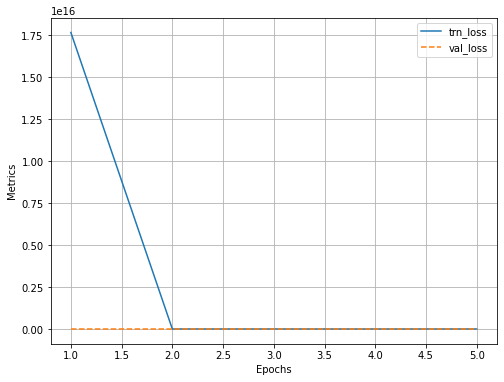

In [43]:
log.plot_epochs(['trn_loss','val_loss'])